## Modelo SIR en parareal (Julia)

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R_{t} & = \nu I 
\end{align}

   
\begin{align}
S_{t} & = - \beta S\cdot I  \\
I_{t} & = \beta S \cdot I - \nu I \\
R(t) & = N - S(t)-I(t)
\end{align}


In [107]:
using LaTeXStrings
# Parámetros

const global N_ind = 103 # Número de individuos
const global beta = 0.08 # Infección
const global nu = 0.75 # Recuperación
const global S0 = 100. # Número de susceptibles
const global I0 = 3. # Número de infectados

const global t_init = 0.
const global t_end  = 5.
t_n_f = 10000
const global t_n_c = 20

const global N_intervalos = 8;
const global T = LinRange(t_init, t_end, N_intervalos+1)

const global n_iter = 10 # Número de iteraciones de Parareal

#Sistema
U0 = [S0 ,I0, N_ind-S0-I0]   # S_0, I_0, R_0

function SIR(U, t)
     S = U[1]
     I = U[2]
     return [-beta*S*I, beta*S*I-nu*I, nu*I]
end

SIR (generic function with 1 method)

## Array de incógintas, $U[i,j,k]$

- Primer índice $i$: subintervalo
- Segundo índice $j$: iteración parareal
- Terecer ínidice $k$: incógnita
    * 1 -> S
    * 2 -> I
    * 3 -> R

## Método de Euler

In [2]:
# Resuelve el sistema de EDO U' = F(U,t), U(0)=U0 en el rango 
# de tiempo T = [t_0, ..., t_n] mediante el método de Euler
function Euler(F, U0, t_init, t_end, n_t)
    dt = (t_end-t_init)/n_t
    t = t_init
    
    #println("n_t=$n_t, t_init=$t_init, t_end=$t_end, dt=$dt")
    U_sol = U0
    for i=1:n_t
        # Denotamos: U=solución en la etapa actual, U0=sol. etapa anterior
        U_sol = U0 + dt*F(U0, t) # U, U0, F(U,t) arrays numpy

        # Preparamos siguiente iteración
        t += dt
        U0 = U_sol
        
        #println("Iter $i, t=$t, u=$U_sol, ex_sol=$(exp(t))")

    end
    return U_sol
end

Euler (generic function with 1 method)

In [3]:
f1(y,t) = y  # y'=y, y(0)=1, solución exacta: y(t)= e^t
y_end = Euler(f1, 1, t_init, t_end, 10)

println("\nListo. Error en t_end=$t_end: ", exp(t_end) - y_end)


Listo. Error en t_end=5.0: 90.7481200400766


 ## Método Parareal

In [4]:
F(t1, t0, u0) =  Euler(SIR, u0, t0, t1, t_n_f)
G(t1, t0, u0) =  Euler(SIR, u0, t0, t1, t_n_c)

G (generic function with 1 method)

In [5]:
function SIR_secuencial()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (secuencial) en cada subintervalo
        @inbounds begin
        for n = 1:N_intervalos
            Fn[n,:] = F( T[n+1], T[n], U[n,k,:] )
        end
        end 
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end
    end
    
    return U
    
end

SIR_secuencial (generic function with 1 method)

In [6]:
function SIR_parareal()
    U = Array{Float64,3}(undef, N_intervalos+1, n_iter+1, 3);
    Fn = Array{Float64,2}(undef, N_intervalos+1, 3);

    # 1.a) Inicialización (aproximción grosera)
    U[1,1,:] = U0
    for n=1:N_intervalos
        U[n+1,1,:] = G( T[n+1],T[n],U[n,1,:] )
    end
        
    # 1.b) Inicialización etapas parareal
    @inbounds Threads.@threads for k=1:n_iter
        U[1,k+1,:] = U0
    end

    # 2) Bucle parareal
    for k=1:n_iter
 
        # 2.a) Aproximación fina (paralela) en cada subintervalo
        begin
        @inbounds Threads.@threads for n = 1:N_intervalos
            Fn[n,:] = F( T[n+1], T[n], U[n,k,:] )
        end 
        end
        
        # 2.b) Corrección secuencial
        @inbounds for n = 1:N_intervalos
            U[n+1, k+1, :] = Fn[n,:] + G( T[n+1], T[n], U[n,k+1,:] ) - G( T[n+1], T[n], U[n,k,:] )
        end
    end
    
    return U
    
end

SIR_parareal (generic function with 1 method)

In [23]:
@time U1 = SIR_secuencial();

  0.882898 seconds (4.82 M allocations: 514.965 MiB, 27.99% gc time)


In [24]:
@time U2 = SIR_parareal();

  0.474360 seconds (4.82 M allocations: 515.094 MiB, 74.55% gc time)


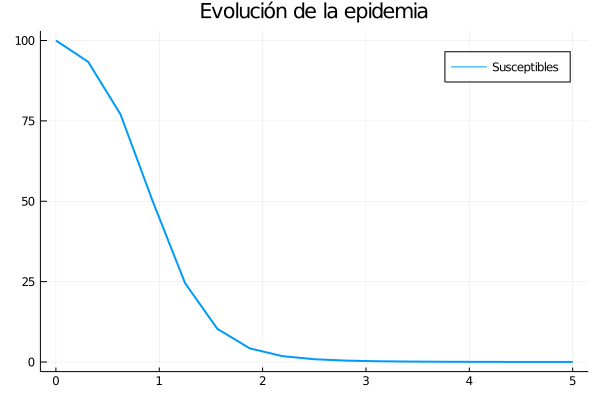

In [55]:
#import Pkg; Pkg.add("Plots")

using Plots

y = U2[:,end,:]; 
y1, y2, y3 = y[:,1], y[:,2], y[:,3]
x = T
plot(x, y1, title = "Evolución de la epidemia", label = ["Susceptibles" "Infectados" "Recuperados"], lw = 2)

## Estudio de los tiempos de computo

### Evolución para N_intervalos = núcleos

In [86]:
time_16= Array{Float64,2}(undef, 5,2);
for i=1:5
    t_n_f = 10000*i
    tiempo = @elapsed SIR_secuencial()
    time_16[i,1] = tiempo
    tiempo = @elapsed SIR_parareal()
    time_16[i,2] = tiempo
end

In [93]:
plotly()
plot(time_array,  time_16, label = ["secuencial" "paralelo"], title = "N_intervalos = núcleos", xlabel="iteraciones finas (x10000)", ylabel="tiempo (s)")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/noelia/.julia/packages/Plots/ninUP/src/backends.jl:375


<!DOCTYPE html>
 
 
 Plots.jl

### Evolución para N_intervalos = 2núcleos

In [105]:
time_32= Array{Float64,2}(undef, 5,2);
for i=1:5
    t_n_f = 10000*i
    tiempo = @elapsed SIR_secuencial()
    time_32[i,1] = tiempo
    tiempo = @elapsed SIR_parareal()
    time_32[i,2] = tiempo
end

In [106]:
plotly()
plot(time_array,  time_32, label = ["secuencial" "paralelo"], title = "N_intervalos = 2*núcleos", xlabel="iteraciones finas (x10000)", ylabel="tiempo (s)")

<!DOCTYPE html>
 
 
 Plots.jl

### Evolución para $\text{N_intervalos} = \frac{\text{núcleos}}{2}$

In [134]:
time_8= Array{Float64,2}(undef, 5,2);
for i=1:5
    t_n_f = 10000*i
    tiempo = @elapsed SIR_secuencial()
    time_8[i,1] = tiempo
    tiempo = @elapsed SIR_parareal()
    time_8[i,2] = tiempo
end

In [135]:
plotly()
plot(time_array,  time_8, label = ["secuencial" "paralelo"], title = "N_intervalos = mitad de núcleos", xlabel="iteraciones finas (x10000)", ylabel="tiempo (s)")

<!DOCTYPE html>
 
 
 Plots.jl